# The ElasticNet results (for the most abundant cell types)

## Outline

The **MLAging Cell-type** workflow consists of four sections:

I. Data Preprocessing in Seurat ```preprocessing.R```

II. ElasticNet tuning (hyperparameter selection for  with ```GridSearchCV```):

III. Final Models Over 10 Random States:
1. [Data Preparation](#1.-prep)
2. [Cell Types](#2.-celltypes)
    - [Neuron](#3.-neuron)
    - [Oligodendrycte](#4.-Oligo)
    - [Astrocyte](#5.-astro)
    - [OPC](#6.-opc)
    - [Microglia](#7.-micro)

IV. Results and Intepretations-- **this notebook**:

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

from src.data_processing import *

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
data_type = 'float32'

import pickle
from statistics import mean, stdev

from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer

## 1. Performance (AUPRC) bar plots <a name="1.-barplot"></a>

In [2]:
cell_types = ['Neuron', 'Oligodendrocyte', 'Astrocyte', 'OPC', 'Microglia']
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [3]:
baseline_df = []
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    baseline_df.append(max(y_test.value_counts())/len(y_test))
    file.close()

In [4]:
df_bar = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'])

for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'Baseline'  
    df_new['AUPRC'] = baseline_df[cell_types.index(i)]
    df_bar = df_bar.append(df_new)

In [5]:
for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'ELN test'
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [6]:
df_bar

,Cell-type,Condition,AUPRC
0,Neuron,Baseline,0.663918
1,Neuron,Baseline,0.663918
2,Neuron,Baseline,0.663918
3,Neuron,Baseline,0.663918
4,Neuron,Baseline,0.663918
...,...,...,...
5,Microglia,ELN test,0.996895
6,Microglia,ELN test,0.996890
7,Microglia,ELN test,0.996895
8,Microglia,ELN test,0.996895


In [7]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

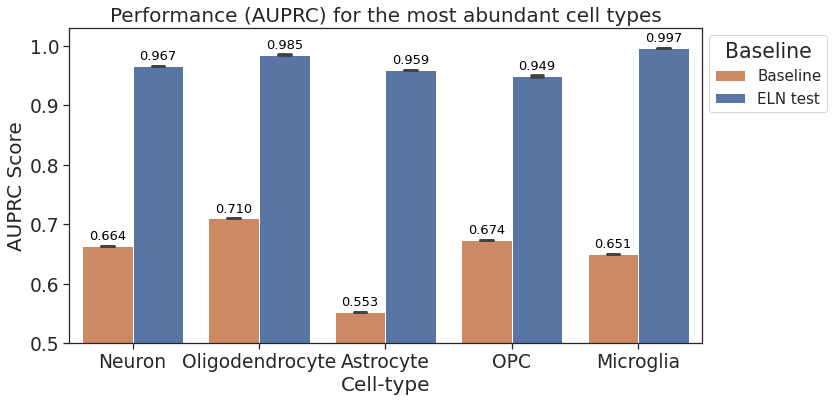

In [9]:
plt.figure(figsize=(12,6))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Cell-type', y='AUPRC', hue='Condition', ci='sd', capsize=.1, 
                 palette=[sns.color_palette()[1], sns.color_palette()[0]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.005, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')

plt.title('Performance (AUPRC) for the most abundant cell types', fontsize=20)
plt.xlabel("Cell-type", fontsize=20)
plt.ylabel("AUPRC Score", fontsize=20)
plt.ylim(0.5, 1.03)
plt.legend(title='Baseline', bbox_to_anchor=(1, 1), fontsize=15)
plt.tight_layout()
plt.savefig('../figures/4b_celltypes_bar_AUPRC.pdf')
plt.show()

## 2. Precision-Recall Curve <a name="2.-prcurve"></a>

In [10]:
# for ML models
def calculate_MLPR(ML_model, test_X, test_y):
    y_test_prob = ML_model.predict_proba(test_X)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_test_prob)
    return recall, precision, auc(recall, precision)

In [11]:
for i in cell_types:
    file = open('../results/cell_type_best/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/cell_type_best/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    file.close()
    locals()[i] = calculate_MLPR(model, X_test, y_test)

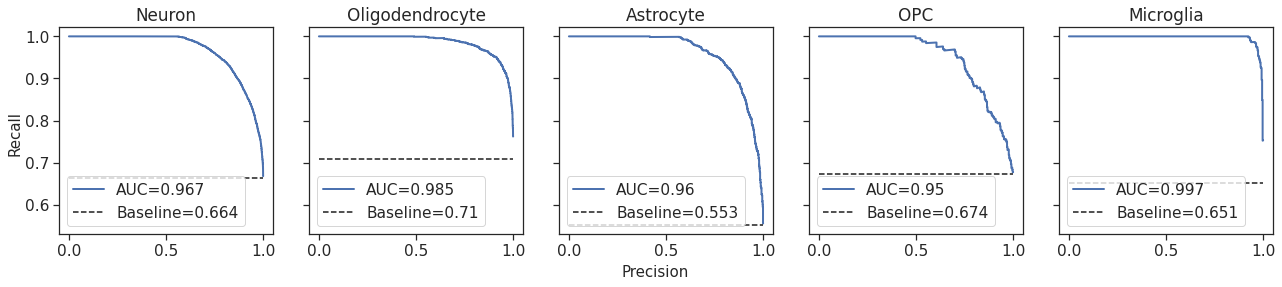

In [13]:
fig, axs  = plt.subplots(1,5, figsize=(18,4), sharey=True)
sns.set(font_scale=1.4, style='ticks')

for i in cell_types:
    recall, precision, auprc = locals()[i]
    baseline = baseline_df[cell_types.index(i)]
    
    number = cell_types.index(i)
    axs[number].plot(recall, precision, 'b ',
                     label=f'AUC={round(auprc, 3)}',lw=2)
    axs[number].plot([0, 1], [baseline, baseline], 'k--' , label=f"Baseline={round(baseline, 3)}")
    
    axs[number].set_title(f'{i}')
    axs[number].legend(loc='lower left')
#     axs[number].legend(bbox_to_anchor=(0.9, 0.4))

fig.text(0.5, 0.0, 'Precision', ha='center', fontsize=15)
fig.text(0.0, 0.5, 'Recall', va='center', rotation='vertical', fontsize=15)

# plt.rcParams.update({'font.size': 10})   
plt.tight_layout()

plt.savefig('../figures/4c_celltype_auprc.pdf')